### Данные телеметрии, описывающие работы одного из узлов сложного технологического оборудования, представлены в файле 'examination_task.csv'. В первом столбце датафрайма data_time представлены дата и время эксплуатации оборудования. Последующие три столбца Parameter1, Paramenter2 и Paramenter3 содержат данные о входных и выходных параметрах, описываемого оборудования. Остальные столбцы датафрайме Rele1..12 содержат информацию о переключении различных реле, которые задают значения входных параметров и различные режимы работы оборудования.

### Первое задание, которое сводится к задаче кластеризации, состоит в выделение трех режимов работы оборудования. В качестве решения необходимо разметить временной ряд и обозначить работу оборудования в том или ином режиме. 

### Во втором задании Вам необходимо определить дату возможной поломки оборудования. Для второго задания наибольший интерес представляет не определение точной даты поломки, а ход Ваших рассуждений по поиску возможной поломки оборудования.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
% matplotlib inline

df = pd.read_csv('examination_task.csv', index_col = 'date_time', parse_dates = ['date_time'])
# print(df[:10])

def print_unique(df):
    for column in df.columns:
        print(column)
        print(np.sort(df[column].unique()))
    return
    
# print_unique(df)
# Rele3 только одно значение. Отбросим столбец

df['Rele5'] = df['Rele5'].astype('int64')
df['Rele11'] = df['Rele11'].astype('int64')
df['Rele12'] = df['Rele12'].astype('int64')
df['Rele3'] = df['Rele12']
df = df.drop('Rele12', axis = 1)

# Посмотрим средние значения за разные периоды, данные с непостоянным периодом. Лучшее оказалось - за 1 минуту
period = '1T'
df_mean = df.resample(period).mean()
df_med = df.resample(period).median()
df_med.columns += '_med'
df_res = pd.concat([df_mean, df_med], axis = 1)
df_res = df_res.dropna()
mms = MinMaxScaler()
columns = df_res.columns
index = df_res.index
df_res = pd.DataFrame(mms.fit_transform(df_res), columns = columns, index = index)

# Попробуем найти кластеры автоматически.
# from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
# km = KMeans(n_clusters = 3)
# df_res = df_res.dropna()
# km = KMeans(n_clusters = 3)
# clust = km.fit_predict(df_res)
# df_res['color'] = clust
# KMeans, MiniBatch, AgglomerativeClustering в лоб ничего не дает
# SpectralClustering надо слишком много памяти и процессора

1    17064
0     1733
2      252
Name: Mode, dtype: int64


/usr/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/lib64/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/lib64/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


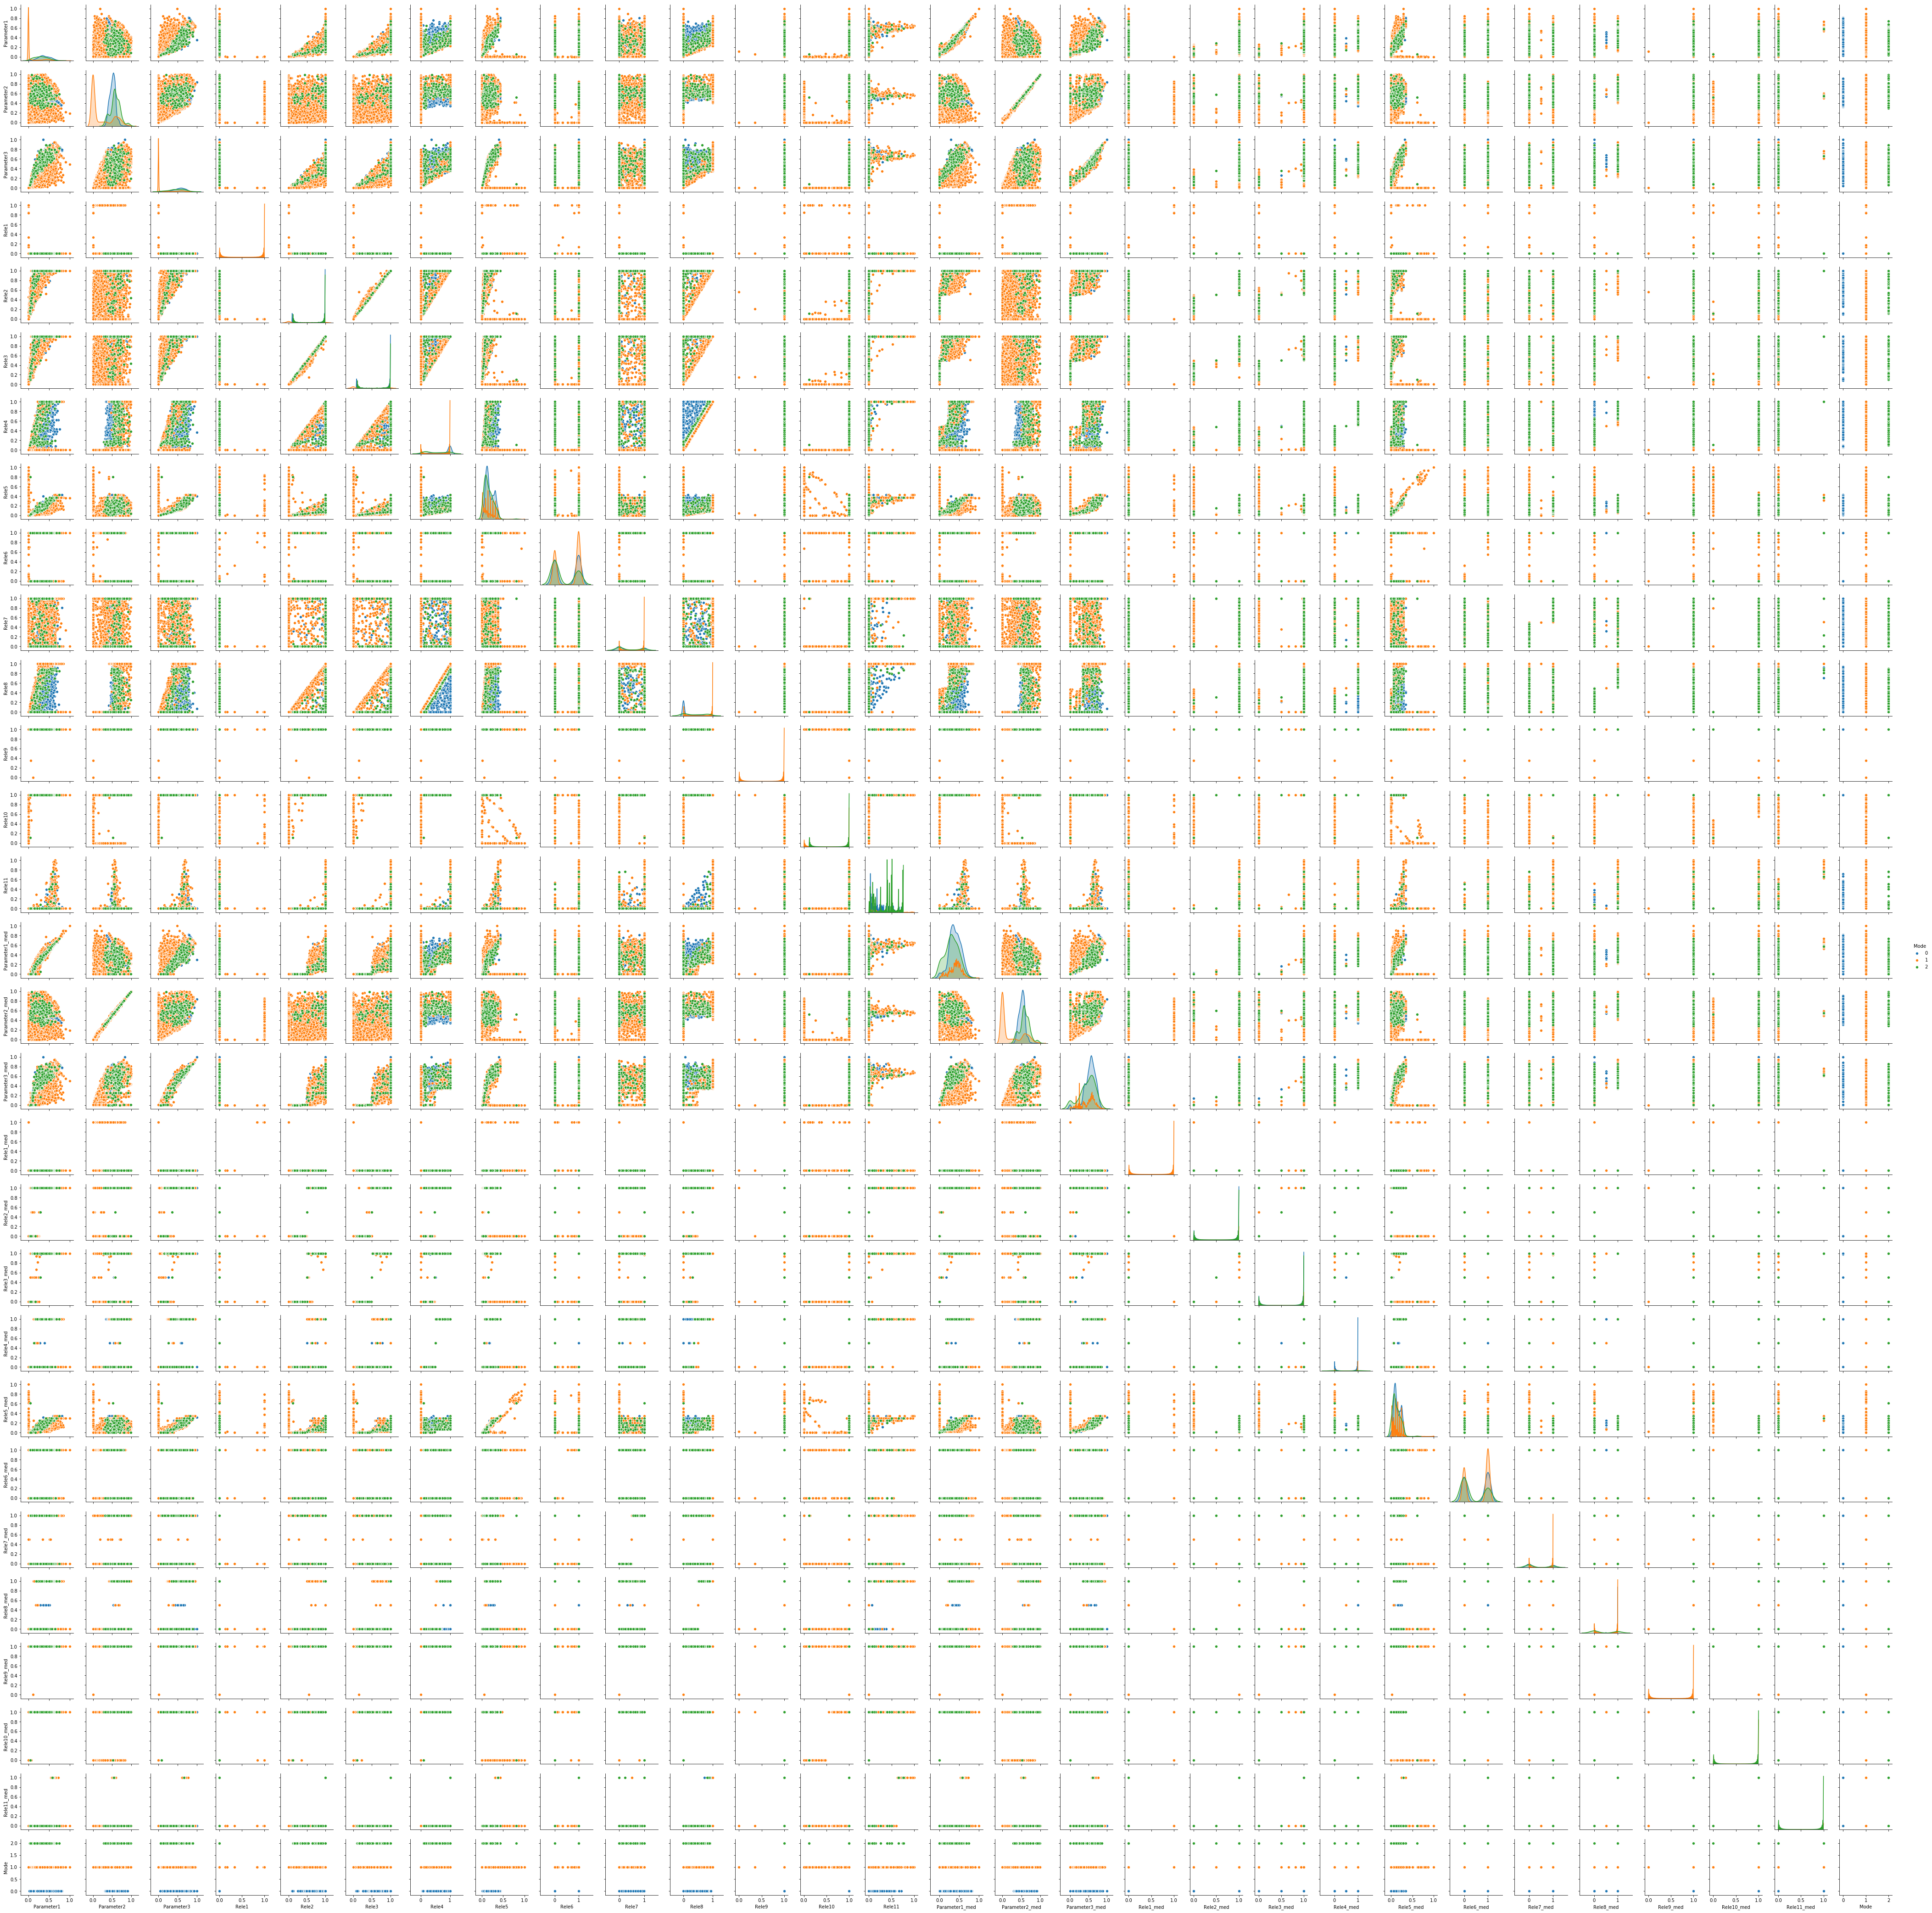

In [2]:
df_res = df_res.dropna()
df_res['Mode'] = 0
#df_res.at[df_res['Rele5'] + df_res['Rele10'] <= 1 , 'Mode'] = 1
#df_res.at[df_res['Rele5'] < 0.05, 'Mode'] = 2
#df_res.at[df_res['Rele10'] >= 0.95, 'Mode'] = 2
#df_res.at[df_res['Rele10'] <= 0.05, 'Mode'] = 2
# 0:20, 1:16, 2:19103 ИМХО мимо
df_res.at[abs(df_res['Rele8'] - df_res['Rele4']) < 0.05, 'Mode'] = 1
df_res.at[abs(df_res['Rele8'] - df_res['Rele4'] + 0.15) < 0.05, 'Mode'] = 2
#0:1733, 1:17064, 2:252
print(df_res['Mode'].value_counts())
# plt.scatter(df_res['Rele4'], df_res['Rele8'], c=df_res['Mode'])

sns_plot = sns.pairplot(df_res, height = 2, hue = 'Mode')
sns_plot.savefig('Pairplot.png')

In [3]:
index = df.index
index1 = df.index.round(freq = 'T')
df.index = index1
df = df.join(df_res['Mode'])
df.index = index
df.to_csv('df_with_modes.csv')

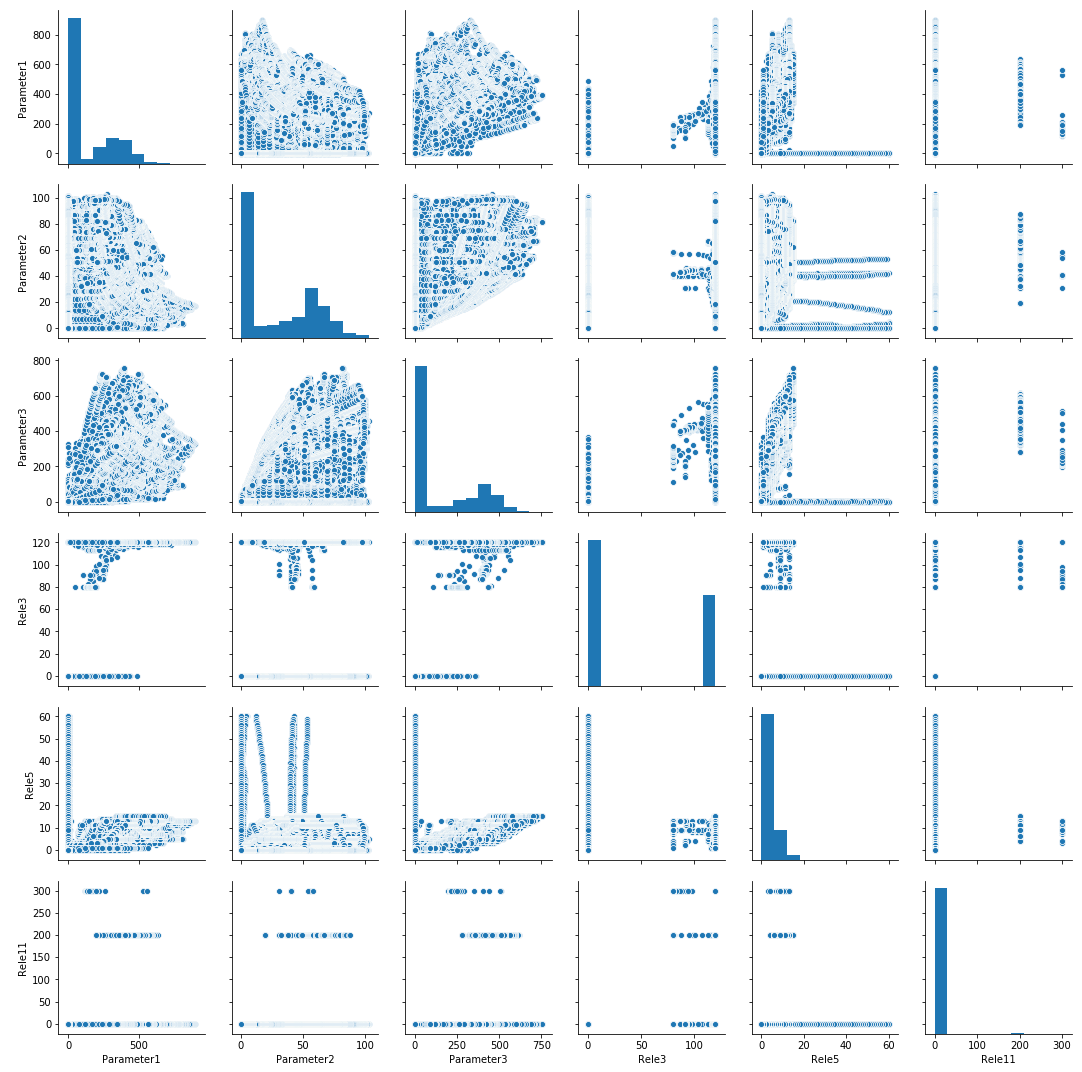

In [4]:
sns.pairplot(df[['Parameter1', 'Parameter2', 'Parameter3', 'Rele3', 'Rele5', 'Rele11']])
# Не показательно вообще

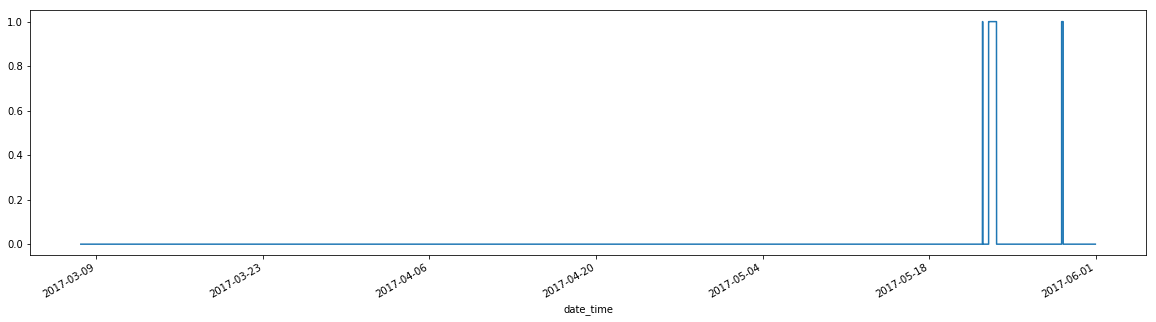

In [5]:
# Просто графики. Напрямую из них вроде бы ничего достать не получается. 
# Частоту по-моему извлекать сомнительно, а вот скважность сигнала - вполне, считаем как среднее.
df['Rele1'].plot(figsize=(20,5))

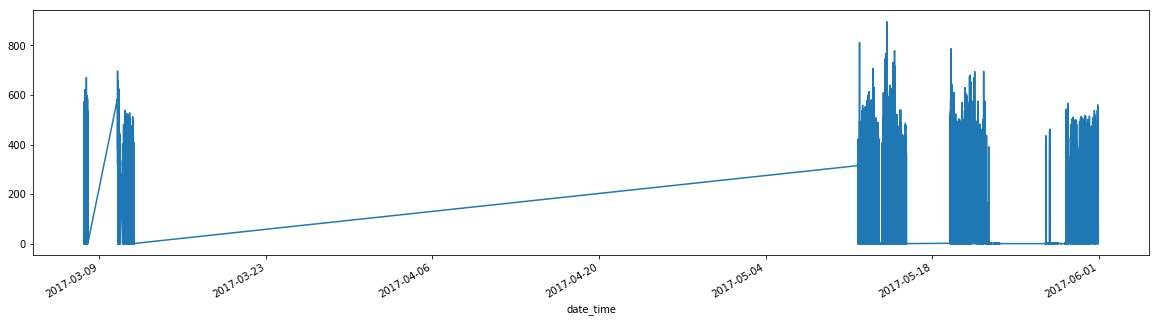

In [6]:
df['Parameter1'].plot(figsize=(20,5))

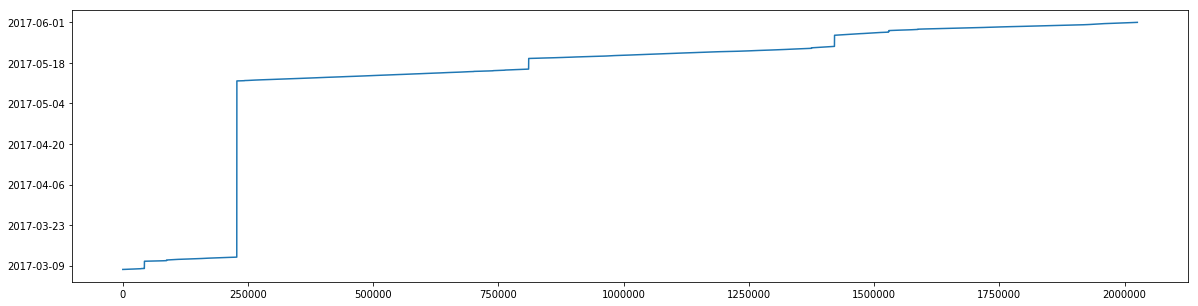

In [7]:
# А тут видно 6 периодов более или менее непрерывной работы установки
pd.Series(df.index).plot(figsize=(20,5))

plt.figure(figsize=(10, 10))
sns_plot = sns.heatmap(df_res.dropna().corr())
fig = sns_plot.get_figure()
fig.savefig('Heatmap.png')

In [8]:
# Думал, что получится разбить на относительно непрерывные периоды работы и посмотреть их отдельно. Стало не особо лучше
dates = []
for i in range(1, len(df.index)):
    if df.index[i] - df.index[i - 1] > dt.timedelta(hours = 6):
        dates.append(df.index[i])
print(dates)

[Timestamp('2017-03-10 13:00:02'), Timestamp('2017-05-11 18:00:03'), Timestamp('2017-05-19 12:00:03'), Timestamp('2017-05-27 12:00:02'), Timestamp('2017-05-29 02:55:52')]


In [15]:
df0 = df.loc[df.index < dt.datetime.strptime('2017-03-10 13:00:02', "%Y-%m-%d %H:%M:%S"), :]
df1 = df.loc[(df.index >= dt.datetime.strptime('2017-03-10 13:00:02', "%Y-%m-%d %H:%M:%S")) & (df.index < dt.datetime.strptime('2017-05-11 18:00:03', "%Y-%m-%d %H:%M:%S")), :]
df2 = df.loc[(df.index >= dt.datetime.strptime('2017-05-11 18:00:03', "%Y-%m-%d %H:%M:%S")) & (df.index < dt.datetime.strptime('2017-05-19 12:00:03', "%Y-%m-%d %H:%M:%S")), :]
df3 = df.loc[(df.index >= dt.datetime.strptime('2017-05-19 12:00:03', "%Y-%m-%d %H:%M:%S")) & (df.index < dt.datetime.strptime('2017-05-27 12:00:02', "%Y-%m-%d %H:%M:%S")), :]
df4 = df.loc[(df.index >= dt.datetime.strptime('2017-05-27 12:00:02', "%Y-%m-%d %H:%M:%S")) & (df.index < dt.datetime.strptime('2017-05-29 02:55:52', "%Y-%m-%d %H:%M:%S")), :]
df5 = df.loc[df.index >= dt.datetime.strptime('2017-05-29 02:55:52', "%Y-%m-%d %H:%M:%S"), :]


In [22]:
corr0 = df0.corr()
corr1 = df1.corr()
corr2 = df2.corr()
corr3 = df3.corr()
corr4 = df4.corr()
corr5 = df5.corr()

In [63]:
corr0

,Parameter1,Parameter2,Parameter3,Rele1,Rele2,Rele3,Rele4,Rele5,Rele6,Rele7,Rele8,Rele9,Rele10,Rele11
Parameter1,1.000000,0.614385,0.945777,NaN,0.929881,0.932665,0.842568,0.966365,NaN,0.479171,0.694752,NaN,NaN,NaN
Parameter2,0.614385,1.000000,0.715420,NaN,0.685113,0.685172,0.711892,0.629089,NaN,0.550819,0.681443,NaN,NaN,NaN
Parameter3,0.945777,0.715420,1.000000,NaN,0.941501,0.944450,0.879687,0.960074,NaN,0.536852,0.725937,NaN,NaN,NaN
Rele1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rele2,0.929881,0.685113,0.941501,NaN,1.000000,0.996594,0.838270,0.877015,NaN,0.480864,0.700035,NaN,NaN,NaN
Rele3,0.932665,0.685172,0.944450,NaN,0.996594,1.000000,0.840836,0.879154,NaN,0.482129,0.702178,NaN,NaN,NaN
Rele4,0.842568,0.711892,0.879687,NaN,0.838270,0.840836,1.000000,0.832466,NaN,0.500370,0.835095,NaN,NaN,NaN
Rele5,0.966365,0.629089,0.960074,NaN,0.877015,0.879154,0.832466,1.000000,NaN,0.516937,0.675734,NaN,NaN,NaN
Rele6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rele7,0.479171,0.550819,0.536852,NaN,0.480864,0.482129,0.500370,0.516937,NaN,1.000000,0.399476,NaN,NaN,NaN


In [62]:
list = [(c, df0[c].value_counts(normalize = True)) for c in df0.columns if 'Rele' in c]
for i in list:
    print(i)

('Rele1', 0    1.0
Name: Rele1, dtype: float64)
('Rele2', 1    0.534617
0    0.465383
Name: Rele2, dtype: float64)
('Rele3', 120    0.533013
0      0.466894
119    0.000023
115    0.000023
112    0.000023
108    0.000023
Name: Rele3, dtype: float64)
('Rele4', 0    0.553331
1    0.446669
Name: Rele4, dtype: float64)
('Rele5', 0     0.464849
13    0.140745
11    0.091668
9     0.086297
7     0.057423
5     0.035802
4     0.022760
6     0.019552
10    0.018250
8     0.017087
2     0.016692
1     0.012508
3     0.009695
12    0.004347
14    0.002325
Name: Rele5, dtype: float64)
('Rele6', 0    1.0
Name: Rele6, dtype: float64)
('Rele7', 0    0.662412
1    0.337588
Name: Rele7, dtype: float64)
('Rele8', 0    0.639815
1    0.360185
Name: Rele8, dtype: float64)
('Rele9', 1    1.0
Name: Rele9, dtype: float64)
('Rele10', 1    1.0
Name: Rele10, dtype: float64)
('Rele11', 0    1.0
Name: Rele11, dtype: float64)


In [5]:
# Точку, где произошел отказ, в данном случае логично посмотреть, как выбросы на pairplot'ах. На перестроенной матрице с усредненными за 2 минуты показаниями наиболее явно выброс отслеживается здесь.
df_res.loc[(abs(df_res['Rele6'] - 0.7) < 0.1) & (abs(df_res['Rele2'] - 0.2) < 0.1), :]
# Еще посмотрел какие значения (средние, медианные) у разных параметров, не меняются ли в течение времени. Ничего толкового не видно. По сути те же усредненные за N времени показания
# Взаимные корреляции параметров тоже посмотрел. Ничего

,Parameter1,Parameter2,Parameter3,Rele1,Rele2,Rele3,Rele4,Rele5,Rele6,Rele7,...,Rele2_med,Rele3_med,Rele4_med,Rele5_med,Rele6_med,Rele7_med,Rele8_med,Rele9_med,Rele10_med,Rele11_med
date_time,,,,,,,,,,,,,,,,,,,,,
2017-05-13 21:48:00,0.021,0.10682,0.009859,0.0,0.174242,0.136364,0.0,0.036025,0.704545,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [64]:
import gc
gc.collect()

1334